# Introduction

In this notebook, we will be building a facial emotion recognition model using the FER-2013 dataset. Our model will be based on the Xception architecture, enhanced with a Convolutional Block Attention Module (CBAM) for improved feature extraction.

# Setup and Configuration
First, we will import the necessary libraries and define the configuration settings for our model.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Dropout, Input, Multiply, Reshape, MaxPooling2D, Conv2D, Add, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Define constants
CONFIG = {
    'INPUT_IMAGE_SIZE': (71, 71),
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 7,
    'L2_REGULARIZATION': 0.01,
    'TRAIN_BATCH_SIZE': 64,
    'TEST_BATCH_SIZE': 64,
    'EPOCHS': 15,
}

# Data Preprocessing
We prepare our data using image augmentation techniques to improve the robustness of our model.

In [2]:
# Load and preprocess the data
def load_data(train_dir, test_dir, img_size, train_batch_size, test_batch_size):
    # Increased data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=test_batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_data, test_data

train_dir = 'data/train'
test_dir = 'data/test'

train_data, test_data = load_data(
    train_dir,
    test_dir,
    img_size=CONFIG['INPUT_IMAGE_SIZE'],
    train_batch_size=CONFIG['TRAIN_BATCH_SIZE'],
    test_batch_size=CONFIG['TEST_BATCH_SIZE']
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Visualization of Class Distribution and calculating class weights
To get a better understanding of our dataset, we visualize the distribution of classes and write a function to compute class weights

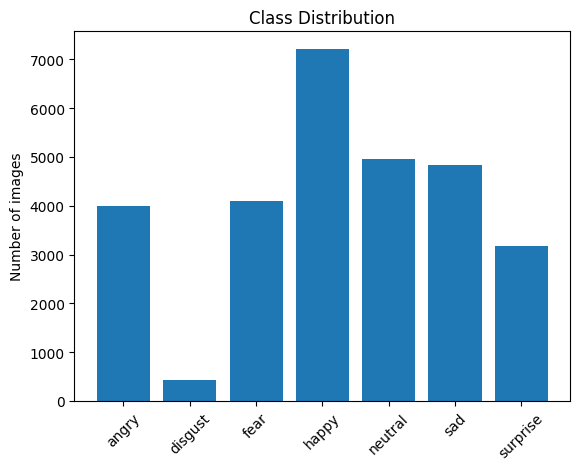

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


In [3]:
# Plot the distribution of classes in the dataset
def plot_class_distribution(train_dir):
    class_counts = {}
    for root, dirs, files in os.walk(train_dir):
        labels = [d for d in dirs if os.path.isdir(os.path.join(root, d))]
        if labels:
            break

    for label in labels:
        path = os.path.join(train_dir, label)
        class_counts[label] = len(os.listdir(path))

    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Number of images')
    plt.savefig('images/class_distribution.png')
    plt.show()

# Call the function to plot class distribution
plot_class_distribution(train_dir)

# Calculate class weights to handle class imbalance
def calculate_class_weights(train_dir):
    class_weights = {}
    class_indices = {}
    for root, dirs, files in os.walk(train_dir):
        labels = [d for d in dirs if os.path.isdir(os.path.join(root, d))]
        if labels:
            break
    class_indices = dict(zip(labels, range(len(labels))))

    # Compute the class weight for each class
    weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    for class_name, class_index in class_indices.items():
        class_weights[class_index] = weights[class_index]

    return class_weights

class_weights = calculate_class_weights(train_dir)

# print class weights
print(class_weights)

# Xception Layer
We encapsulate the Xception model within a custom Keras layer, which allows us to represent the model as a single block in `model.summary()`.

In [4]:
# Xception layer
class XceptionLayer(Layer):
    def __init__(self, input_shape, **kwargs):
        super(XceptionLayer, self).__init__(**kwargs)
        self.xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    def call(self, inputs):
        return self.xception(inputs)

# CBAM Layer
The CBAM module is implemented as a custom layer to enhance our model's attention to important features in the image.

In [5]:
# CBAM layer
class CBAMLayer(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Channel Attention
        self.channel_avg_pool = GlobalAveragePooling2D()
        self.channel_max_pool = MaxPooling2D()
        self.channel_dense_1 = Dense(input_shape[-1] // self.reduction_ratio, activation='relu')
        self.channel_dense_2 = Dense(input_shape[-1], activation='sigmoid')

        # Spatial Attention
        self.spatial_conv = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel attention
        channel_avg_pool = self.channel_avg_pool(inputs)
        channel_max_pool = self.channel_max_pool(inputs)
        channel_avg_pool = Reshape((1, 1, -1))(channel_avg_pool)
        channel_max_pool = Reshape((1, 1, -1))(channel_max_pool)
        channel_avg_pool = self.channel_dense_1(channel_avg_pool)
        channel_max_pool = self.channel_dense_1(channel_max_pool)
        channel_avg_pool = self.channel_dense_2(channel_avg_pool)
        channel_max_pool = self.channel_dense_2(channel_max_pool)
        channel_attention = Add()([channel_avg_pool, channel_max_pool])
        channel_attention = Multiply()([inputs, channel_attention])

        # Spatial attention
        avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
        max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.spatial_conv(concat)
        spatial_attention = Multiply()([channel_attention, spatial_attention])

        return spatial_attention

# Model Creation
Using our custom layers, we assemble the entire model, applying L2 regularization and using the Adam optimizer.

In [6]:
# Create_transfer_model function including the Xception and CBAM layers, use Adam, and apply L2 regularization
def create_transfer_model(input_shape, num_classes, l2_reg=CONFIG['L2_REGULARIZATION']):
    inputs = Input(shape=input_shape)
    x = XceptionLayer(input_shape)(inputs)  
    x = CBAMLayer()(x)  

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=CONFIG['LEARNING_RATE'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model = create_transfer_model(input_shape=(*CONFIG['INPUT_IMAGE_SIZE'], 3), num_classes=CONFIG['NUM_CLASSES'])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 xception_layer (XceptionLa  (None, 3, 3, 2048)        20861480  
 yer)                                                            
                                                                 
 cbam_layer (CBAMLayer)      (None, 3, 3, 2048)        526563    
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0   

# Callbacks
We define various callbacks to monitor training, including early stopping and learning rate reduction on plateaus.

In [7]:
# Define callbacks
def create_callbacks():
    log_dir = "logs/fit/xception_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
        ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

callbacks = create_callbacks()

# Training the Model
With everything set up, we train our model on the FER-2013 dataset, using class weights to handle imbalances.

In [8]:
# Function to train and evaluate the model
def train_and_evaluate_model(model, train_data, test_data, epochs, callbacks, class_weights):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    return history

history = train_and_evaluate_model(model, train_data, test_data, CONFIG['EPOCHS'], callbacks, class_weights)

Epoch 1/15


449/449 [==============================] - ETA: 0s - loss: 1.8949 - accuracy: 0.4736
Epoch 1: val_accuracy improved from -inf to 0.52995, saving model to best_xception_model.keras
449/449 [==============================] - 414s 885ms/step - loss: 1.8949 - accuracy: 0.4736 - val_loss: 1.4100 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 2/15
116/449 [======>.......................] - ETA: 3:42 - loss: 1.2786 - accuracy: 0.5575

# Evaluation
Post-training, we evaluate our model's performance and visualize the results with classification reports and confusion matrices.

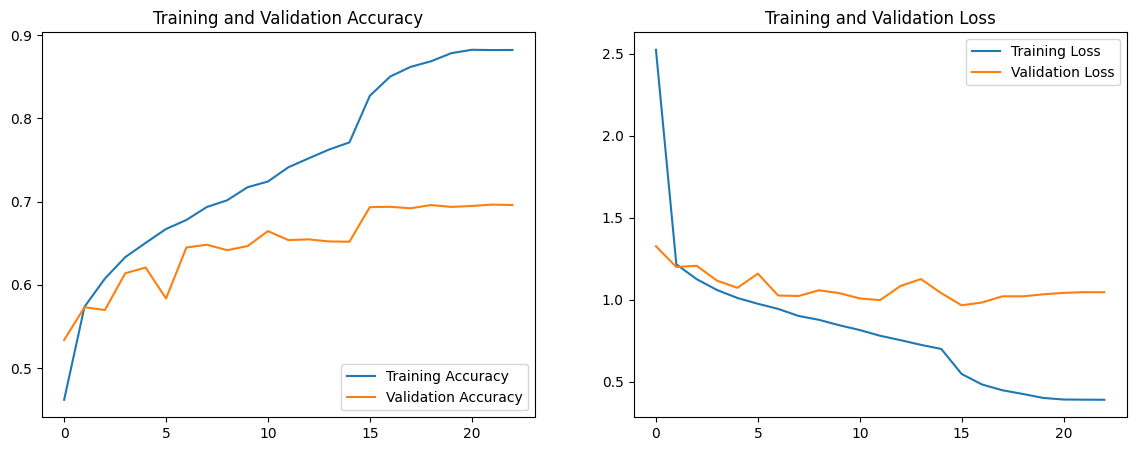

Test Loss: 0.9664, Test Accuracy: 0.6934


W0000 00:00:1711330457.193565     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.61      0.62       958
     disgust       0.70      0.66      0.68       111
        fear       0.63      0.47      0.54      1024
       happy       0.90      0.87      0.88      1774
     neutral       0.60      0.70      0.65      1233
         sad       0.54      0.62      0.58      1247
    surprise       0.85      0.79      0.82       831

    accuracy                           0.69      7178
   macro avg       0.69      0.67      0.68      7178
weighted avg       0.70      0.69      0.69      7178



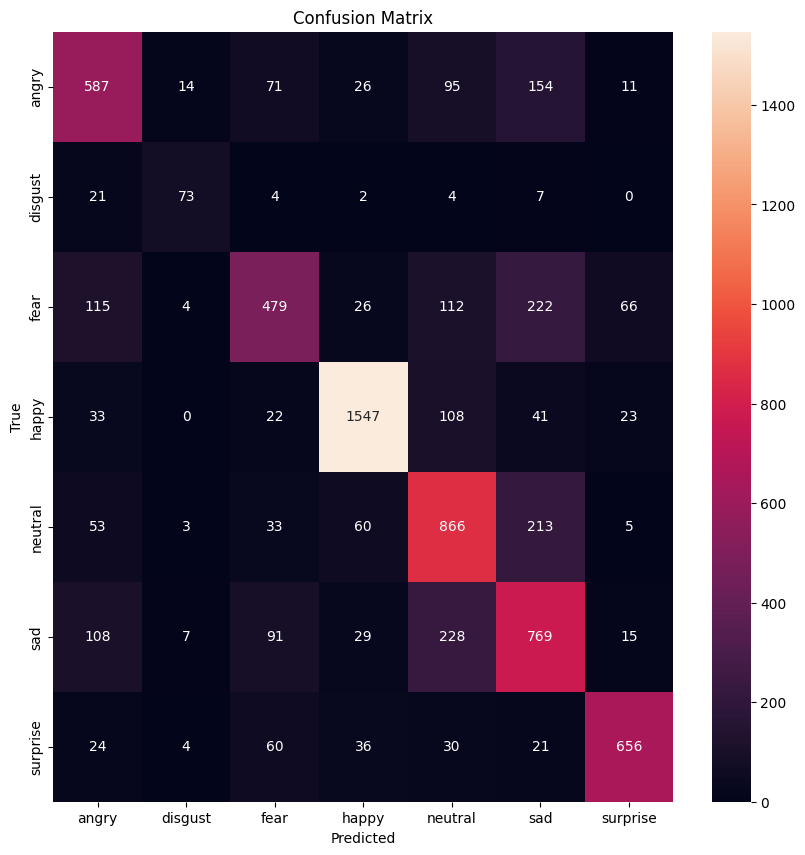

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('images/metrics.png')
    plt.show()

# Function to evaluate the model and display classification metrics
def evaluate_model(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    predictions = model.predict(test_data, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('images/confusion_matrix.png')
    plt.show()
    
plot_metrics(history)
evaluate_model(model, test_data)

# Model Architecture Visualization
For a clear picture of our model's architecture, we visualize it using `plot_model`.

In [ ]:
# Function to visualize the model using plot_model
def visualize_model(model):
    plot_model(model, to_file='images/model_architecture.png', show_shapes=True, show_layer_names=True)

# Visualize the model architecture
visualize_model(model)

# Sample Predictions
Let's see how our model performs on some sample images from the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


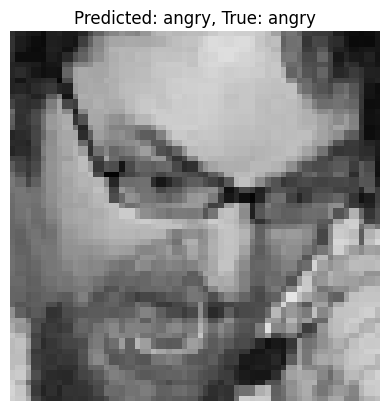

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


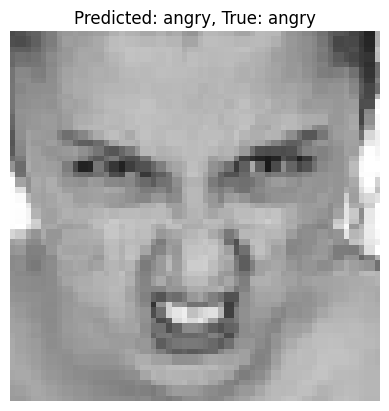

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


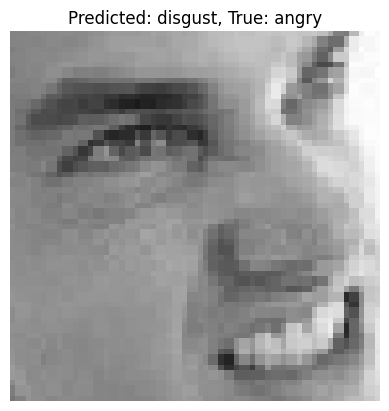

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


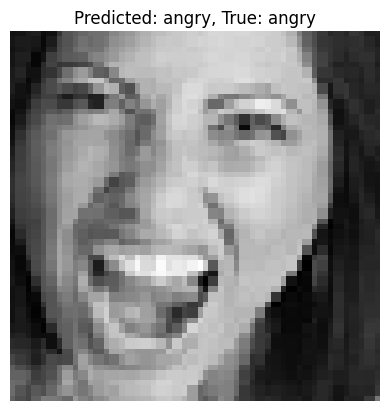

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


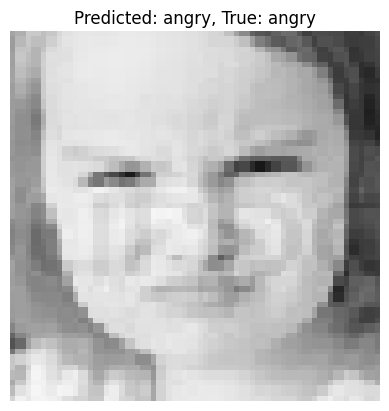

In [ ]:
# Visualize real images and their predicted labels
def plot_images_with_predictions(test_data, model, num_images=5):
    class_labels = list(test_data.class_indices.keys())  # Ensure class_labels are available
    for i in range(num_images):
        x, y = test_data.__next__() 
        image = x[0]
        true_index = np.argmax(y[0])
        predicted_index = np.argmax(model.predict(np.expand_dims(image, axis=0))[0])
        plt.imshow(image)
        plt.title(f'Predicted: {class_labels[predicted_index]}, True: {class_labels[true_index]}')
        plt.axis('off')
        plt.savefig(f'images/predictions_{i}.png')
        plt.show()

# Call the function to plot images with predictions
plot_images_with_predictions(test_data, model)

# Augmentation Effects
Show how different data augmentation techniques affect the images.

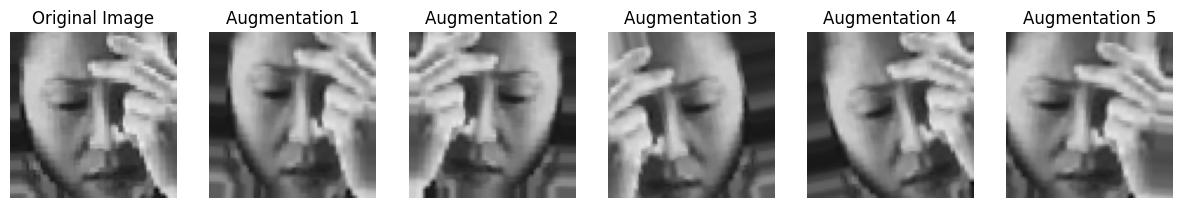

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to visualize data augmentation effects
def visualize_augmentation(datagen, original_img, augmentations=5):
    # Assume original_img is coming from the generator, which means it's already rescaled
    original_img = np.expand_dims(original_img, axis=0)  # Add batch dimension
    plt.figure(figsize=(15, 3))
    
    # Display original image
    plt.subplot(1, augmentations + 1, 1)
    plt.imshow(original_img[0])
    plt.title('Original Image')
    plt.axis('off')
    
    # Generate and display augmented images
    for i in range(augmentations):
        aug_iter = datagen.flow(original_img, batch_size=1)
        aug_img = next(aug_iter)[0]  # Access the augmented image
        plt.subplot(1, augmentations + 1, i + 2)
        plt.imshow(aug_img)
        plt.title(f'Augmentation {i+1}')
        plt.axis('off')
    
    plt.savefig('images/data_augmentation.png')
    plt.show()

# Fetch a single image from the generator
for x, _ in train_data:
    original_img = x[0]  # Taking the first image from the batch
    break
    
# Call the function to visualize augmentation effects
visualize_augmentation(train_datagen, original_img)

# Error Analysis
Identify misclassified images and visualize them.

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


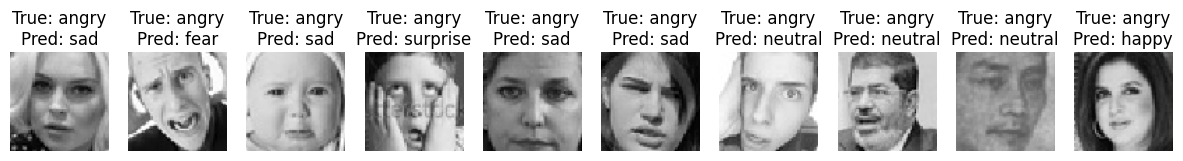

In [ ]:
# Function to visualize misclassified images
def visualize_misclassified_images(test_data, model, class_indices, num_images=10):
    class_labels = list(class_indices)  # Convert dict_keys to a list
    misclassified = []
    
    # Fetch batch from test_data
    for images, true_labels in test_data:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(true_labels, axis=1)
        
        # Iterate over images and labels
        for img, true, pred in zip(images, true_labels, pred_labels):
            if true != pred:
                misclassified.append((img, class_labels[true], class_labels[pred]))
            if len(misclassified) >= num_images:
                break
        
        # Break outer loop if we already have enough misclassified examples
        if len(misclassified) >= num_images:
            break

    # Plot misclassified images
    plt.figure(figsize=(15, 4))
    for i, (img, true_label, pred_label) in enumerate(misclassified[:num_images]):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.savefig('images/misclassified_images.png')
    plt.show()

# Call the function to visualize misclassified images
visualize_misclassified_images(test_data, model, class_indices=test_data.class_indices)

# TensorBoard Integration
To monitor our training progress in more detail, we can use TensorBoard.

In [ ]:
! tensorboard --logdir logs/fit